## Object-Oriented Data Processing and Analysis Pipeline (Image-based)
### Group 8

In this project, we created a modular pipeline that works with satellite images: loading them, extracting key features, analyzing the data, and visualizing the results. The entire process is built using object-oriented programming (OOP) in Python to keep the code clear, organized, and easy to manage.

#### Importing Libraries
We start by importing the essential libraries for image processing, numerical analysis, and visualization.


In [21]:
import os                           # For working with file paths and directories
import numpy as np                  # For numerical operations and array handling
import pandas as pd                 # For working with data tables (DataFrames)
from PIL import Image               # For opening and processing image files
import matplotlib.pyplot as plt     # For creating visualizations with matplotlib
import time                         # For tracking execution time
import seaborn as sns               # For improved and styled visualizations
from collections import Counter     # For counting occurrences, used in color binning
import warnings                     # Used to suppress or manage warning messages for cleaner notebook output

## DataLoader Class

The `DataLoader` class handles the very first step of our pipeline — loading images from a folder. It checks for valid image files, supports multiple formats, and can resize images if needed. 

The images are returned as NumPy arrays in a dictionary where each key is the filename.

In [22]:
class DataLoader:
    def __init__(self, folder_path, supported_formats=None):
        
        #Initializes the DataLoader.
        #Args:
        #    folder_path (str): Path to the image directory.
        #    supported_formats (tuple): Supported image file extensions.

        # Checking if the dataset folder exists
        if not os.path.isdir(folder_path):
            raise ValueError(f" Error: Dataset folder not found at {folder_path}")
        
        self.folder_path = folder_path

        # Usign default formats if none are specified
        self.supported_formats = supported_formats or ('.jpg', '.jpeg', '.png', '.bmp')

        # Filtering image files by format
        self.image_files = [f for f in os.listdir(folder_path)
                            if f.lower().endswith(self.supported_formats)]

        # If no valid image files are found, raising an error
        if not self.image_files:
            raise ValueError(f" No supported image files found in {folder_path}")

        print(f"📁 Found {len(self.image_files)} image(s) in {folder_path}")

    def load_images(self, max_images=None, resize_to=None):
    
        # The `load_images()` method reads each image file, converts it to RGB, and optionally resizes it. 
        # Images are stored as NumPy arrays in a dictionary. It also tracks and reports any loading errors.

        #Args:
        #    max_images (int): Max number of images to load (optional).
        #    resize_to (tuple): Resize each image to (width, height), e.g., (128, 128)
        #Returns:
        #    dict: {filename: numpy RGB array}

        images_data = {}        # Stores the final image data
        loaded_count = 0        # Track successfully loaded images
        failed_count = 0        # Track failures

        # Limiting how many files to load (if max_images is set)
        files_to_load = self.image_files[:max_images] if max_images else self.image_files

        print("🔄 Starting image loading...")
        start_time = time.time()

        for filename in files_to_load:
            file_path = os.path.join(self.folder_path, filename)
            try:
                # Open the image and convert to RGB
                with Image.open(file_path) as img:
                    img = img.convert('RGB')
                    # Resize if required
                    if resize_to:
                        img = img.resize(resize_to)
                    # Store the image as a NumPy array
                    images_data[filename] = np.array(img)
                    loaded_count += 1
            except Exception as e:
                print(f"⚠️ Warning: Could not load '{filename}': {e}")
                failed_count += 1

        end_time = time.time()
        print(f"✅ Loaded {loaded_count} image successfully.")
        if failed_count > 0:
            print(f"❌ Failed to load {failed_count} image(s).")
        print(f"⏱️ Time taken: {end_time - start_time:.2f} seconds\n")

        return images_data

In [23]:
# Setting the path to image dataset
dataset_path = "./Dataset"  

# Creating a DataLoader instance
loader = DataLoader(folder_path=dataset_path)

# Loading images (limit to 500 and resize to 128x128)
images_dict = loader.load_images(max_images=500, resize_to=(128, 128))

# Final confirmation
print(f"🎯 Image loading complete. Total images in memory: {len(images_dict)}")

📁 Found 1093 image(s) in ./Dataset
🔄 Starting image loading...
✅ Loaded 500 image successfully.
⏱️ Time taken: 0.50 seconds

🎯 Image loading complete. Total images in memory: 500


## FeatureExtractor Class

In this step, we compute detailed color features for each image. Instead of just working in grayscale, we analyze the red, green, and blue channels separately.

We extract the following features:
- **Mean R, G, B**: average intensity per color channel
- **Std R, G, B**: how much each color channel varies
- **Aspect Ratio**: width-to-height of the image
- **Image Size**: total number of pixels
- **Predominant Color**: the most frequent RGB color, grouped by bins (color clusters)


In [24]:
class FeatureExtractor:
    def __init__(self, num_bins_per_channel):
        # Initializing the number of bins for each RGB channel
        self.num_bins = num_bins_per_channel

        # Calculating the size of each bin (e.g., if 6 bins: 256 // 6 = 44)
        self.bin_size = 256 // self.num_bins

        # Defining bin edges from 0 to 256 (inclusive) in steps of bin_size
        self.bin_edges = np.arange(0, 257, self.bin_size)

    def _get_bin_center_color(self, bin_indices):
        # Converting bin indices into approximate RGB values using bin centers
        return tuple(
            int((self.bin_edges[i] + self.bin_edges[i + 1]) / 2)
            for i in bin_indices
        )

    def extract_features(self, images_data):
        # Listing to hold extracted feature dictionaries
        features = []

        # Looping through each image in the dataset
        for filename, img_array in images_data.items():
            try:
                # Getting image dimensions
                h, w, _ = img_array.shape
                aspect_ratio = round(w / h, 2)
                size = h * w

                # Flattening image to a 2D array of pixels
                pixels = img_array.reshape(-1, 3)

                # Calculating mean and standard deviation for R, G, B channels
                mean_r, mean_g, mean_b = np.mean(pixels, axis=0).round(2)
                std_r, std_g, std_b = np.std(pixels, axis=0).round(2)

                # Bin each color channel into discrete levels
                r_idx = np.clip(np.digitize(pixels[:, 0], self.bin_edges) - 1, 0, self.num_bins - 1)
                g_idx = np.clip(np.digitize(pixels[:, 1], self.bin_edges) - 1, 0, self.num_bins - 1)
                b_idx = np.clip(np.digitize(pixels[:, 2], self.bin_edges) - 1, 0, self.num_bins - 1)

                # Combining RGB bin indices into a list of tuples
                bin_indices = list(zip(r_idx, g_idx, b_idx))

                # Counting the most frequent RGB bin (predominant color)
                most_common = Counter(bin_indices).most_common(1)
                if most_common:
                    bin_idx = most_common[0][0]
                    predominant_color = self._get_bin_center_color(bin_idx)
                else:
                    predominant_color = (0, 0, 0)

                # Storing all extracted features in a dictionary
                features.append({
                    'filename': filename,
                    'mean_r': mean_r,
                    'mean_g': mean_g,
                    'mean_b': mean_b,
                    'std_r': std_r,
                    'std_g': std_g,
                    'std_b': std_b,
                    'aspect_ratio': aspect_ratio,
                    'size': size,
                    'predominant_color_rgb': predominant_color
                })

            except Exception as e:
                # Handling corrupted or unreadable images
                print(f"❌ Error processing {filename}: {e}")

        # Converting the list of dictionaries into a pandas DataFrame
        return pd.DataFrame(features)

In [25]:
# Creating the extractor with 4 bins per RGB channel
extractor = FeatureExtractor(num_bins_per_channel=6)

# Extracting features from the image dictionary
features_df = extractor.extract_features(images_dict)

# Previewing the first 5 rows of the feature DataFrame
features_df.head()

,filename,mean_r,mean_g,mean_b,std_r,std_g,std_b,aspect_ratio,size,predominant_color_rgb
0,00623.jpg,102.32,100.98,96.84,36.14,28.43,28.14,1.0,16384,"(63, 63, 63)"
1,00624.jpg,117.67,114.95,109.77,42.67,43.13,42.31,1.0,16384,"(147, 147, 147)"
2,00625.jpg,100.55,97.58,92.20,42.77,40.51,37.50,1.0,16384,"(63, 63, 63)"
3,00626.jpg,124.23,121.38,113.81,40.89,40.23,36.20,1.0,16384,"(147, 147, 147)"
4,00627.jpg,123.92,119.26,110.20,44.76,42.64,39.68,1.0,16384,"(105, 105, 105)"


## DataAnalyzer Class

In this step, we analyze the feature data we extracted earlier. We categorize each image into geographic types like "Water", "Vegetation", or "Urban" based on color and brightness patterns.

The analyzer also provides:
- A count of images in each category
- Average RGB values per category
- Extended statistics like mean and std for all key features

In [26]:
class DataAnalyzer:
    def __init__(self):
        pass

    def _map_to_category(self, row):
        # Extracting key RGB values and brightness
        R, G, B = row['predominant_color_rgb']
        mean_r, mean_g, mean_b = row['mean_r'], row['mean_g'], row['mean_b']
        std_r, std_g, std_b = row['std_r'], row['std_g'], row['std_b']
        brightness = (mean_r + mean_g + mean_b) / 3

        # Rule 1: Bright + low variance → likely Snow/Ice/Cloud
        if brightness > 210 and max(std_r, std_g, std_b) < 30:
            return 'Snow/Ice/Cloud'

        # Rule 2: Blue much stronger than Red/Green → Water
        if mean_b > mean_r + 20 and mean_b > mean_g + 20 and mean_b > 80:
            return 'Water'

        # Rule 3: Green dominant → likely Vegetation
        if mean_g > mean_r + 10 and mean_g > mean_b + 10 and mean_g > 60:
            return 'Vegetation'

        # Rule 4: Red > Green > Blue and moderate brightness → Barren
        if mean_r > mean_g + 10 and mean_g > mean_b + 10 and 80 < brightness < 180:
            return 'Barren/Arid'

        # Rule 5: R, G, B close in value with medium brightness → Urban
        if abs(mean_r - mean_g) < 30 and abs(mean_g - mean_b) < 30 and 60 < brightness < 210:
            return 'Urban/Built-up'

        # Otherwise → Unknown
        return 'Unknown'

    def analyze_features(self, df):
        # Classifying all rows using the category mapping rules
        print("🧠 Classifying images based on combined features...")
        df['GeographicFeature'] = df.apply(self._map_to_category, axis=1)

        # Printing category distribution
        category_counts = df['GeographicFeature'].value_counts()
        print("\n📊 Category Distribution:")
        print(category_counts)

        # Printing the most common category
        top_cat = category_counts.idxmax()
        print(f"\n🏆 Most common category: {top_cat} ({category_counts[top_cat]} images)")

        return df, category_counts

    def compute_average_rgb_by_category(self, df):
        # Splitting the predominant_color_rgb column into R, G, B for group averaging
        df[['R', 'G', 'B']] = pd.DataFrame(df['predominant_color_rgb'].tolist(), index=df.index)

        # Computing and print mean RGB per category
        means = df.groupby('GeographicFeature')[['R', 'G', 'B']].mean().round(1)
        print("\n🎨 Average RGB by Category:")
        print(means)
        return means

    def compute_extended_statistics(self, df):
        # Defining which numeric columns to summarize
        numeric_cols = ['mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b', 'size', 'aspect_ratio']

        # Grouping by category and compute mean/std for each feature
        print("\n📈 Summary Statistics by Category:")
        summary = df.groupby('GeographicFeature')[numeric_cols].agg(['mean', 'std']).round(2)
        print(summary)
        return summary
    
    def sort_by_brightness(self, df, ascending=False):
        # Calculating average brightness per image
        df['brightness'] = (df['mean_r'] + df['mean_g'] + df['mean_b']) / 3

        # Sorting the DataFrame based on brightness
        sorted_df = df.sort_values(by='brightness', ascending=ascending)

        # Reseting index for readability
        return sorted_df.reset_index(drop=True)


### Run the Data Analysis

Now we apply the analyzer to the features we extracted. This will classify each image, print category counts, and give us deeper insight into the data.

In [27]:
# Create analyzer object
analyzer = DataAnalyzer()

# Run classification and get category counts
features_df, category_counts = analyzer.analyze_features(features_df)

# Compute average RGB per category
avg_colors = analyzer.compute_average_rgb_by_category(features_df)

# Compute summary stats for all numeric features
summary_stats = analyzer.compute_extended_statistics(features_df)

# Sort images from brightest to darkest
sorted_df = analyzer.sort_by_brightness(features_df, ascending=False)

# Show top 5 brightest images
sorted_df[['filename', 'brightness', 'GeographicFeature']].head()

🧠 Classifying images based on combined features...

📊 Category Distribution:
GeographicFeature
Urban/Built-up    383
Barren/Arid        43
Unknown            41
Vegetation         32
Snow/Ice/Cloud      1
Name: count, dtype: int64

🏆 Most common category: Urban/Built-up (383 images)

🎨 Average RGB by Category:
                       R      G      B
GeographicFeature                     
Barren/Arid        182.2  151.9  122.6
Snow/Ice/Cloud     231.0  231.0  189.0
Unknown             91.7   85.5   74.3
Urban/Built-up      96.7   98.7   95.2
Vegetation          84.0  101.1   85.3

📈 Summary Statistics by Category:
                   mean_r         mean_g         mean_b         std_r         \
                     mean    std    mean    std    mean    std   mean    std   
GeographicFeature                                                              
Barren/Arid        179.15  32.64  148.54  24.15  118.11  19.03  14.22   8.73   
Snow/Ice/Cloud     238.10    NaN  227.06    NaN  197.53    N

,filename,brightness,GeographicFeature
0,bareland_63.jpg,220.896667,Snow/Ice/Cloud
1,desert_6.jpg,199.663333,Unknown
2,desert_60.jpg,198.956667,Unknown
3,industrial_48.jpg,196.050000,Urban/Built-up
4,beach_41.jpg,194.693333,Vegetation


## Visualizer Class

This class is responsible for generating insightful visualizations of our analyzed image data. We use both `matplotlib` and `seaborn` to create clear, polished plots including:

- Category distribution
- Predominant color analysis
- RGB scatter comparisons
- Average RGB by category


In [28]:
# Optional: suppress unwanted warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Global Seaborn theme
sns.set_theme(style="whitegrid", font_scale=1.1)

class Visualizer:
    def plot_category_distribution(self, counts):
        # Bar Chart
        plt.figure(figsize=(10, 6))
        sns.barplot(x=counts.index, y=counts.values, palette=sns.color_palette("pastel", len(counts)))
        plt.title('Category Distribution')
        plt.xlabel('Geographic Feature')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)

        for i, val in enumerate(counts.values):
            plt.text(i, val + 0.5, str(val), ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Improved Pie Chart with explode for visibility
        plt.figure(figsize=(8, 8))

        # Sort and prepare data
        counts_sorted = counts.sort_values(ascending=False)
        labels = counts_sorted.index.tolist()
        sizes = counts_sorted.values
        explode = [0.05 if size / sum(sizes) < 0.1 else 0 for size in sizes]  # separate small slices

        plt.pie(
            sizes,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette("Set3"),
            explode=explode,
            textprops={'fontsize': 10}
        )
        plt.title('Category Proportions')
        plt.tight_layout()
        plt.show()

    def plot_color_component_histograms(self, df):
        # Extract RGB components
        R, G, B = zip(*df['predominant_color_rgb'])

        plt.figure(figsize=(10, 6))
        sns.histplot(R, color='red', kde=True, label='Red', bins=16, alpha=0.5)
        sns.histplot(G, color='green', kde=True, label='Green', bins=16, alpha=0.5)
        sns.histplot(B, color='blue', kde=True, label='Blue', bins=16, alpha=0.5)
        plt.title('Distribution of Predominant Color Components')
        plt.xlabel('Color Intensity (0–255)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_red_green_scatter_by_category(self, df):
        plt.figure(figsize=(10, 6))
        for category in df['GeographicFeature'].unique():
            sub = df[df['GeographicFeature'] == category]
            R = [c[0] for c in sub['predominant_color_rgb']]
            G = [c[1] for c in sub['predominant_color_rgb']]
            sns.scatterplot(x=R, y=G, label=category, s=60, alpha=0.6)

        plt.title('Red vs Green Intensity by Category')
        plt.xlabel('Red Intensity')
        plt.ylabel('Green Intensity')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_avg_rgb_by_category(self, rgb_means_df):
        plt.figure(figsize=(10, 6))
        rgb_means_df.plot(kind='bar', ax=plt.gca(), color=['#e74c3c', '#2ecc71', '#3498db'])
        plt.title('Average RGB Values by Category')
        plt.xlabel('Geographic Feature')
        plt.ylabel('Average Intensity')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    def plot_brightness_boxplot(self, df):
        if 'brightness' not in df.columns:
            df['brightness'] = (df['mean_r'] + df['mean_g'] + df['mean_b']) / 3

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='GeographicFeature', y='brightness', data=df, palette='Set2')
        plt.title('Brightness Distribution by Category')
        plt.xlabel('Geographic Feature')
        plt.ylabel('Brightness')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_feature_correlation_heatmap(self, df):
        # Only keep numeric columns
        corr_df = df.select_dtypes(include='number')

        corr = corr_df.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Feature Correlation Heatmap')
        plt.tight_layout()
        plt.show()

    def generate_all_plots(self, df, counts, rgb_means_df):
        print("Generating visualizations...")
        self.plot_category_distribution(counts)
        self.plot_color_component_histograms(df)
        self.plot_red_green_scatter_by_category(df)
        self.plot_avg_rgb_by_category(rgb_means_df)
        self.plot_brightness_boxplot(df)
        self.plot_feature_correlation_heatmap(df)
        print("All visualizations complete.")

### Generate All Visualizations

Now let’s run the `generate_all_plots()` method to create all four enhanced visualizations.

Generating visualizations...


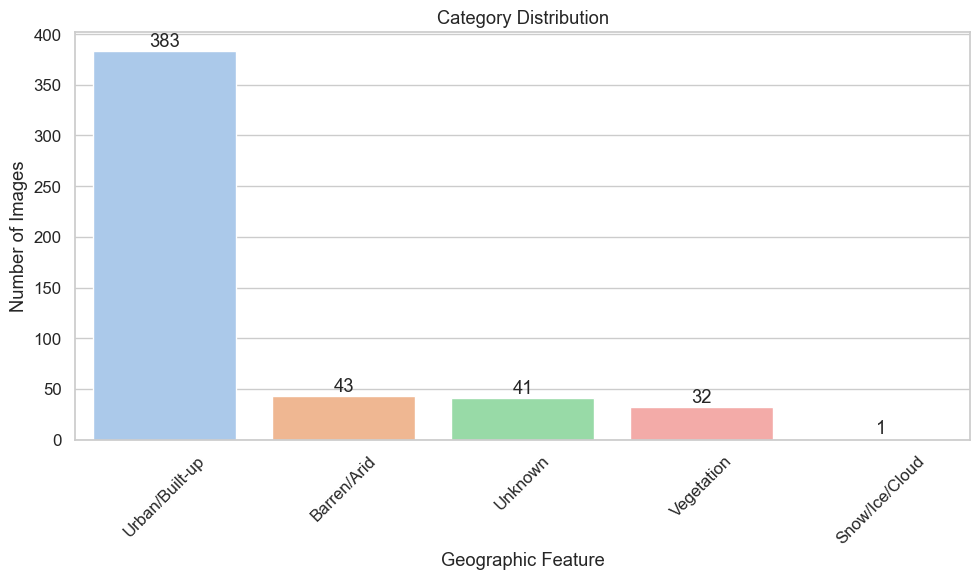

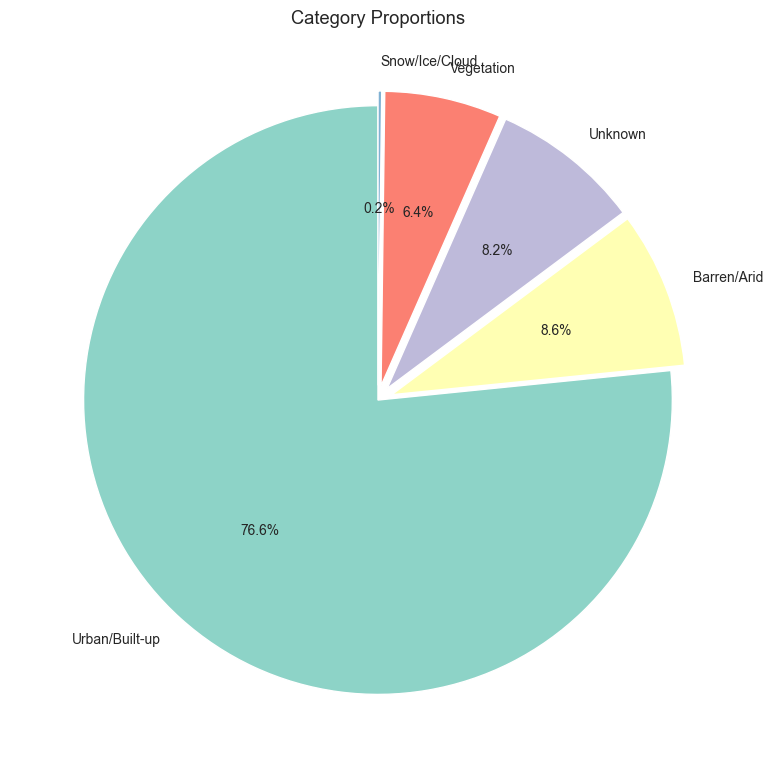

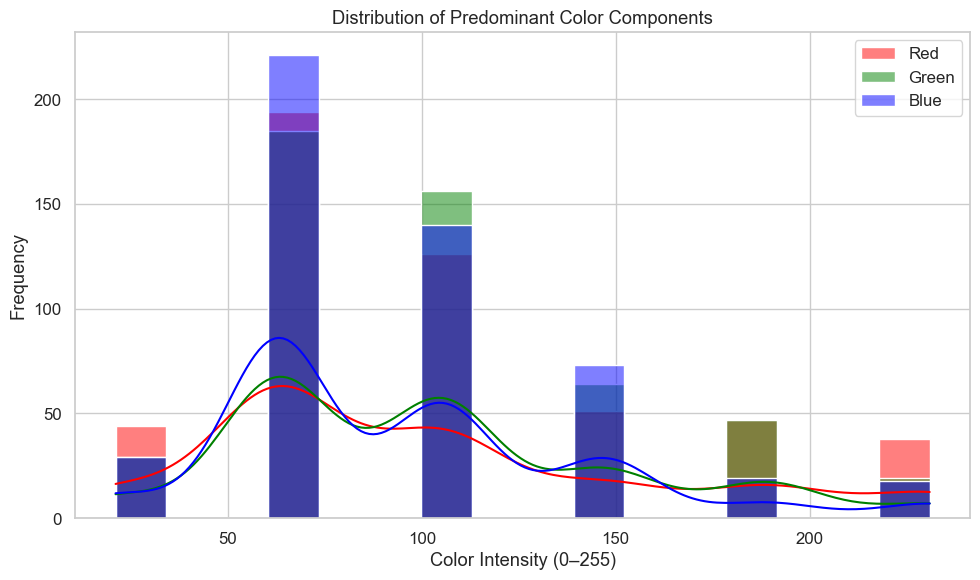

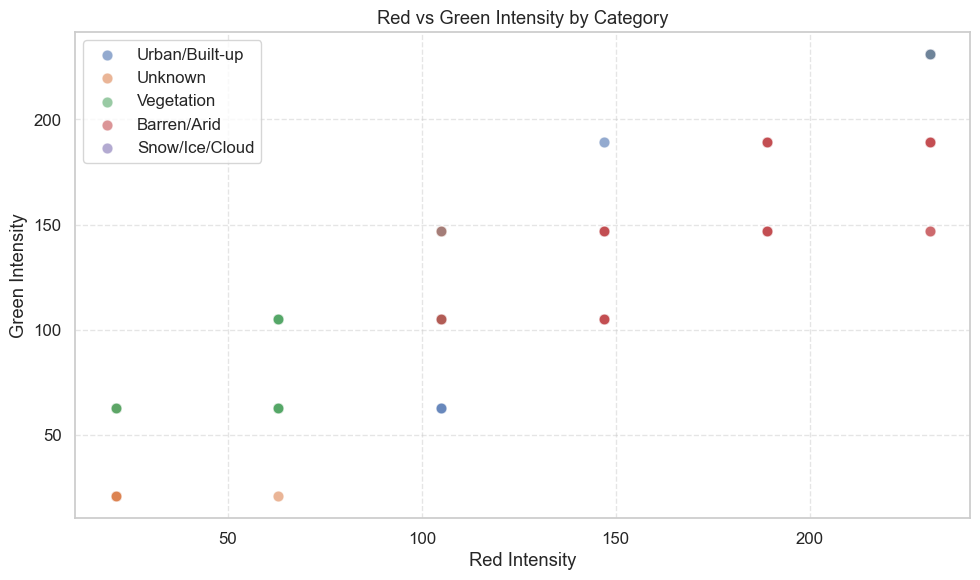

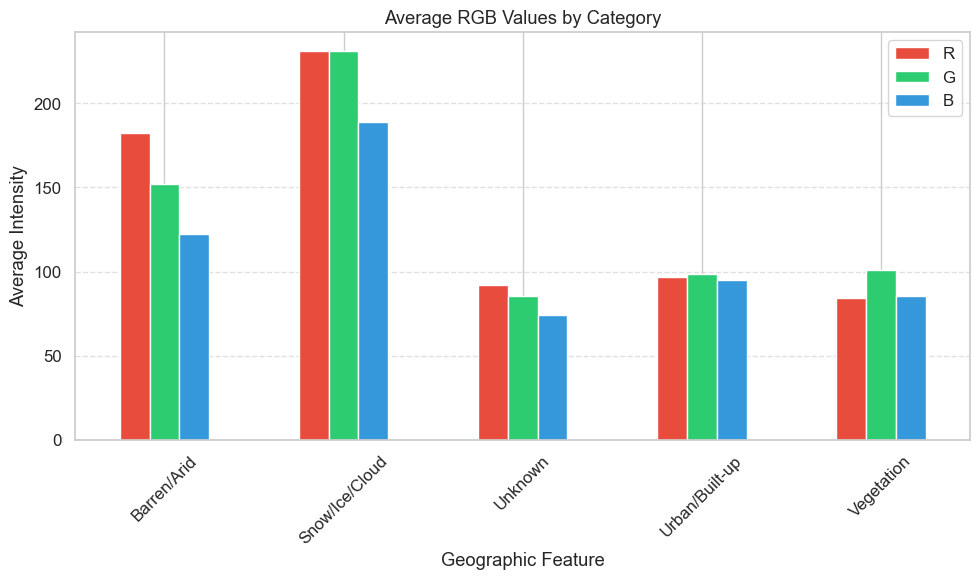

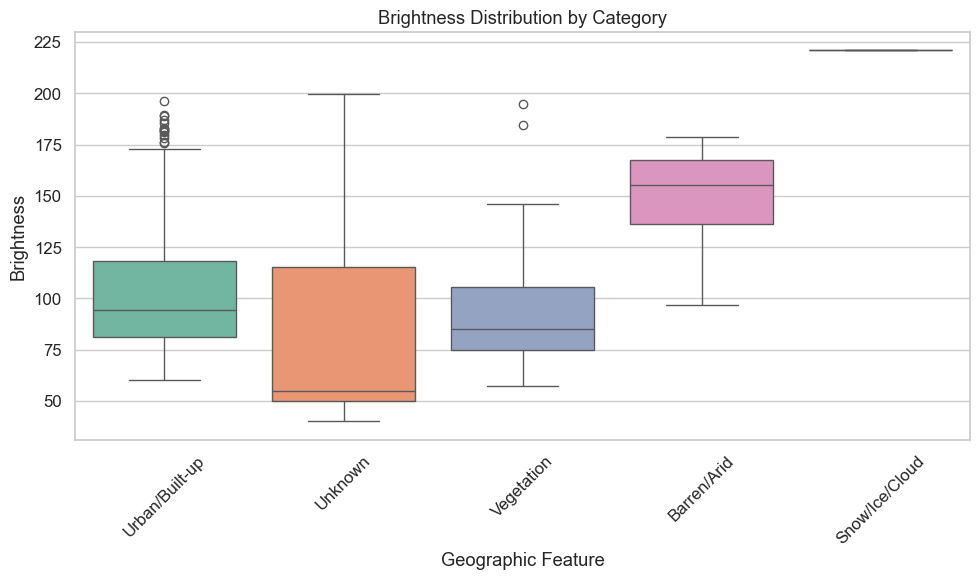

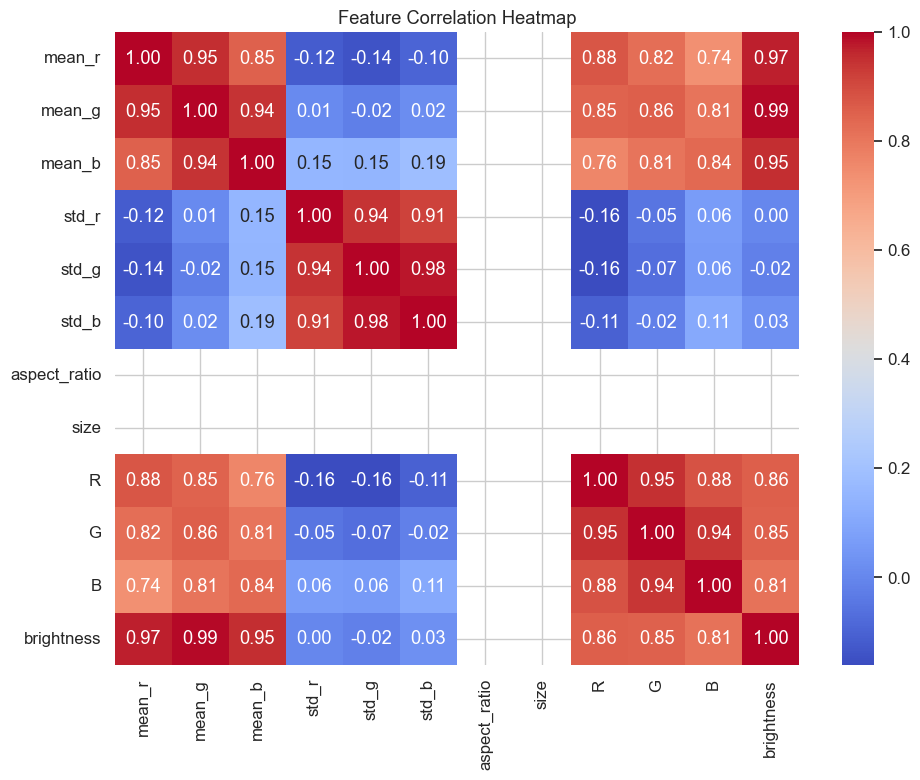

All visualizations complete.


In [29]:
viz = Visualizer()
viz.generate_all_plots(features_df, category_counts, avg_colors)

### Dealing with "Unknown" Images

Since our dataset contains a wide variety of satellite images, not all of them fit neatly into the defined categories such as Vegetation, Water, or Urban. To account for this variation, we labeled images that did not meet any of our classification rules as `"Unknown"`.

Rather than ignoring them, we analyze these images separately to identify any potential patterns or characteristics that may justify creating new categories or adjusting our classification logic.

Below, we:
- Isolate the images labeled as `"Unknown"`
- Summarize their key features (color, brightness, size)
- Visualize distributions to better understand how they differ



🧐 Found 41 images labeled as 'Unknown'.

Summary statistics for 'Unknown' images:


,mean_r,mean_g,mean_b,std_r,std_g,std_b,brightness,size
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.0
mean,96.613659,92.867317,77.411463,21.506829,21.203415,19.254878,88.964146,16384.0
std,75.940954,59.168997,43.772728,11.908185,11.113982,9.862372,59.102347,0.0
min,32.250000,45.230000,35.300000,3.460000,3.280000,3.920000,40.216667,16384.0
25%,47.700000,54.560000,46.830000,11.200000,11.830000,10.160000,50.160000,16384.0
50%,56.110000,59.580000,53.220000,20.730000,21.060000,18.650000,55.086667,16384.0
75%,132.710000,126.240000,126.470000,30.730000,29.390000,25.620000,115.276667,16384.0
max,241.970000,203.700000,156.090000,47.270000,42.060000,40.730000,199.663333,16384.0



📊 Average brightness of all images: 105.65
📊 Average brightness of 'Unknown' images: 88.96

📏 Average size of all images: 16384.00
📏 Average size of 'Unknown' images: 16384.00


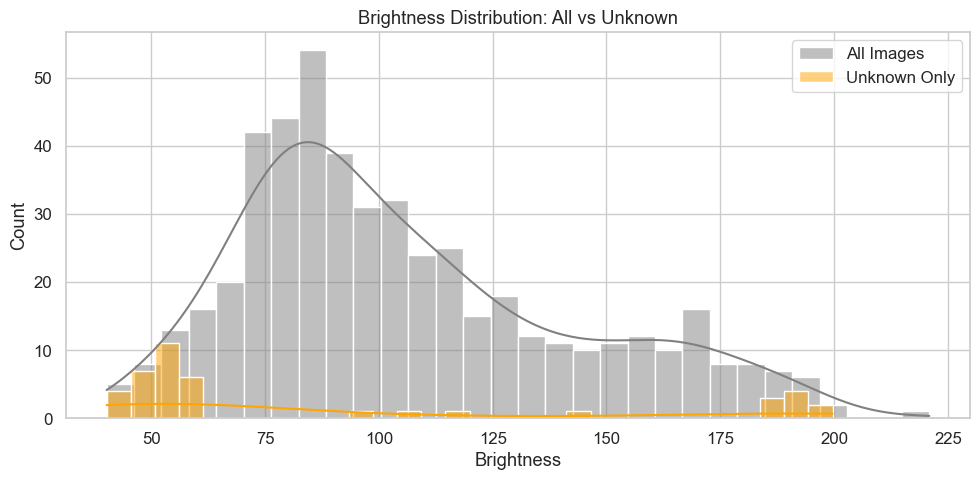

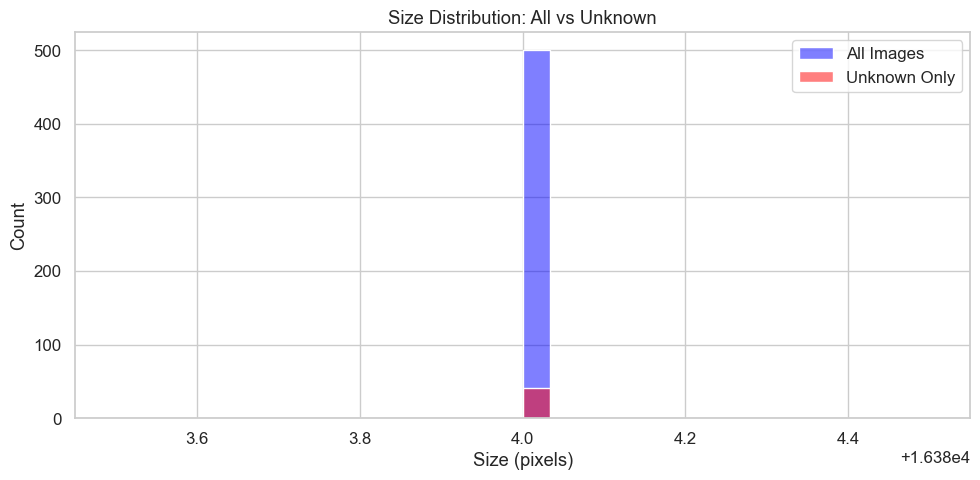

In [30]:
# Analyzing Images Labeled as "Unknown"

# Step 1: Filter unknowns
unknown_df = features_df[features_df['GeographicFeature'] == 'Unknown']
print(f"\n🧐 Found {len(unknown_df)} images labeled as 'Unknown'.")

# Step 2: Displaying summary statistics
print("\nSummary statistics for 'Unknown' images:")
display(unknown_df[['mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b', 'brightness', 'size']].describe())

# Step 3: Comparing mean brightness and size to overall dataset
overall_brightness = features_df['brightness'].mean()
unknown_brightness = unknown_df['brightness'].mean()
overall_size = features_df['size'].mean()
unknown_size = unknown_df['size'].mean()

print(f"\n📊 Average brightness of all images: {overall_brightness:.2f}")
print(f"📊 Average brightness of 'Unknown' images: {unknown_brightness:.2f}")
print(f"\n📏 Average size of all images: {overall_size:.2f}")
print(f"📏 Average size of 'Unknown' images: {unknown_size:.2f}")

# Step 4: Plotting brightness and size distributions
plt.figure(figsize=(10, 5))
sns.histplot(features_df['brightness'], bins=30, color='gray', label='All Images', kde=True)
sns.histplot(unknown_df['brightness'], bins=30, color='orange', label='Unknown Only', kde=True)
plt.title("Brightness Distribution: All vs Unknown")
plt.xlabel("Brightness")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(features_df['size'], bins=30, color='blue', label='All Images', kde=True)
sns.histplot(unknown_df['size'], bins=30, color='red', label='Unknown Only', kde=True)
plt.title("Size Distribution: All vs Unknown")
plt.xlabel("Size (pixels)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

## Final Summary

### Key Takeaways
- We built a fully functional image analysis pipeline that can process hundreds of satellite images efficiently.
- Using Python and object-oriented programming, we kept our code modular and easy to manage.
- Our approach made it possible to extract meaningful features — like color distribution, brightness, and shape — and use those to classify images into different geographic categories.
- Visualizations helped us clearly see the differences between categories and explore patterns in the data.

### What We Learned
- How to work with real-world image data and apply data science techniques to extract and analyze visual features.
- The importance of designing a clean codebase using classes and reusable functions.
- How to use libraries like NumPy, Pandas, Matplotlib, and Seaborn in combination to turn raw image pixels into insights.
- How to think critically about classification logic and handle edge cases, especially when images don’t clearly fit into any category.